In [2]:
!pip install mediapipe==0.10.9 opencv-python matplotlib scikit-learn tensorflow --quiet

^C


  You can safely remove it manually.
  You can safely remove it manually.


In [ ]:
!pip install keras-tuner --upgrade



   -------------------- ------------------- 1/2 [keras-tuner]
   -------------------- ------------------- 1/2 [keras-tuner]
   ---------------------------------------- 2/2 [keras-tuner]



In [ ]:
import os
import random
import numpy as np
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras_tuner import RandomSearch, Hyperband, BayesianOptimization, Objective
from tensorflow.keras.metrics import MeanMetricWrapper

In [ ]:
# ==== CONFIG ====
DATA_DIR   = r"D:\Projects\Age_Gender_classifier\UTKFace\images_flat\part1"
IMG_SIZE   = 64
SIGMA      = 2.0          # Gaussian spread for LDL
ALPHA      = 1.0          # weight for age loss
BETA       = 1.0          # weight for gender loss
BATCH_SIZE = 64
EPOCHS     = 15

AGE_MAX  = 100
NUM_BINS = AGE_MAX + 1                      # 0..100 → 101 bins
AGE_GRID = np.arange(NUM_BINS, dtype=np.float32)

In [ ]:
# Properly create the face detector (your line was jammed together before)
mp_face = mp.solutions.face_detection.FaceDetection(
    model_selection=0, 
    min_detection_confidence=0.6
)


In [ ]:
# ==== FACE ALIGN/CROP ====
def align_crop(img, img_size=IMG_SIZE):
    h, w = img.shape[:2]
    res = mp_face.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    if not res.detections:
        return None
    box = res.detections[0].location_data.relative_bounding_box
    x0 = int((box.xmin - 0.05) * w)
    y0 = int((box.ymin - 0.05) * h)
    x1 = int((box.xmin + box.width + 0.05) * w)
    y1 = int((box.ymin + box.height + 0.05) * h)
    x0, y0 = max(0, x0), max(0, y0)
    x1, y1 = min(w, x1), min(h, y1)
    crop = img[y0:y1, x0:x1]
    if crop.size == 0:
        return None
    return cv2.resize(crop, (img_size, img_size))

In [ ]:
# ==== LOAD DATA ====
X, ages, gender_lbl = [], [], []
bad_files = 0

file_list = sorted([f for f in os.listdir(DATA_DIR) if f.lower().endswith(".jpg")])
total = len(file_list)
print(f"📦 Found {total} image files.")

for idx, fn in enumerate(file_list):
    if idx % 100 == 0:
        print(f"🔄 Processing {idx}/{total}...")

    parts = fn.split("_")
    try:
        age, gender = map(int, parts[:2])
    except Exception:
        bad_files += 1
        continue

    age = int(np.clip(age, 0, AGE_MAX))

    img = cv2.imread(os.path.join(DATA_DIR, fn))
    if img is None:
        bad_files += 1
        continue

    face = align_crop(img)
    if face is None:
        continue

    X.append(face.astype("float32") / 255.0)
    ages.append(age)
    gender_lbl.append([1, 0] if gender == 0 else [0, 1])

X = np.asarray(X, dtype=np.float32)
ages = np.asarray(ages, dtype=np.float32)               # exact ages
gender_lbl = np.asarray(gender_lbl, dtype=np.float32)

print(f"\n✅ Finished loading and aligning faces: {X.shape}")
print(f"⚠️ Skipped {bad_files} malformed or unreadable files.")

📦 Found 10137 image files.
🔄 Processing 0/10137...
🔄 Processing 100/10137...
🔄 Processing 200/10137...
🔄 Processing 300/10137...
🔄 Processing 400/10137...
🔄 Processing 500/10137...
🔄 Processing 600/10137...
🔄 Processing 700/10137...
🔄 Processing 800/10137...
🔄 Processing 900/10137...
🔄 Processing 1000/10137...
🔄 Processing 1100/10137...
🔄 Processing 1200/10137...
🔄 Processing 1300/10137...
🔄 Processing 1400/10137...
🔄 Processing 1500/10137...
🔄 Processing 1600/10137...
🔄 Processing 1700/10137...
🔄 Processing 1800/10137...
🔄 Processing 1900/10137...
🔄 Processing 2000/10137...
🔄 Processing 2100/10137...
🔄 Processing 2200/10137...
🔄 Processing 2300/10137...
🔄 Processing 2400/10137...
🔄 Processing 2500/10137...
🔄 Processing 2600/10137...
🔄 Processing 2700/10137...
🔄 Processing 2800/10137...
🔄 Processing 2900/10137...
🔄 Processing 3000/10137...
🔄 Processing 3100/10137...
🔄 Processing 3200/10137...
🔄 Processing 3300/10137...
🔄 Processing 3400/10137...
🔄 Processing 3500/10137...
🔄 Processing 

In [ ]:
# ==== LDL: exact ages -> Gaussian distributions over 0..100 ====
def ages_to_distributions(ages, sigma=SIGMA):
    # Vectorized Gaussian around each exact age on AGE_GRID
    diffs = AGE_GRID[None, :] - ages[:, None]
    dists = np.exp(-(diffs ** 2) / (2 * sigma**2))
    dists /= dists.sum(axis=1, keepdims=True)
    return dists.astype(np.float32)

age_dist = ages_to_distributions(ages)

In [ ]:
# ==== SPLIT (stratify by age decade + gender) ====
from collections import defaultdict
train_idx, val_idx = [], []
gender_ids = np.argmax(gender_lbl, axis=1)              # 0=male, 1=female
age_decile = np.clip((ages // 10).astype(int), 0, 10)   # 0..10

label_groups = defaultdict(list)
for i, (ad, g) in enumerate(zip(age_decile, gender_ids)):
    label_groups[(ad, g)].append(i)

for (ad, g), idxs in label_groups.items():
    idxs = np.array(idxs)
    np.random.shuffle(idxs)
    if len(idxs) > 2:
        split = int(0.8 * len(idxs))
        train_idx.extend(idxs[:split])
        val_idx.extend(idxs[split:])
    else:
        train_idx.extend(idxs)  # too few → keep in train

X_train, X_val = X[train_idx], X[val_idx]
y_age_tr, y_age_val = age_dist[train_idx], age_dist[val_idx]
y_gen_tr, y_gen_val = gender_lbl[train_idx], gender_lbl[val_idx]
ages_val = ages[val_idx]  # for true-age MAE reporting

print(f"Train: {X_train.shape}, Val: {X_val.shape}")


Train: (8031, 64, 64, 3), Val: (2019, 64, 64, 3)


In [ ]:
# ==== EMD LOSS + AGE MAE METRIC (in years) ====
@tf.function
def emd_loss(y_true, y_pred):
    # y_true, y_pred are distributions over bins
    # if last layer already softmax, this is safe (won't change)
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0)
    cdf_true = tf.math.cumsum(y_true, axis=1)
    cdf_pred = tf.math.cumsum(y_pred, axis=1)
    emd = tf.reduce_mean(tf.abs(cdf_true - cdf_pred), axis=1)  # L1 version
    return tf.reduce_mean(emd)

def mae_from_distribution(y_true, y_pred):
    grid = tf.cast(tf.range(NUM_BINS), tf.float32)                # 0..100
    exp_true = tf.tensordot(y_true, grid, axes=[[1], [0]])       # (batch,)
    exp_pred = tf.tensordot(y_pred, grid, axes=[[1], [0]])       # (batch,)
    return tf.reduce_mean(tf.abs(exp_true - exp_pred))


In [ ]:
# ==== Build tf.data.Dataset ====
train_ds = tf.data.Dataset.from_tensor_slices(
    (X_train, {"age": y_age_tr, "gender": y_gen_tr})
).shuffle(buffer_size=1024).batch(32).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices(
    (X_val, {"age": y_age_val, "gender": y_gen_val})
).batch(32).prefetch(tf.data.AUTOTUNE)


In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))



KeyboardInterrupt: 

In [ ]:
# ==== 1. Build function ====
def build_model(hp):
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = tf.keras.layers.Conv2D(
        filters=hp.Choice("filters1", [32, 64, 128]),
        kernel_size=hp.Choice("kernel1", [3, 5]),
        padding="same", activation="relu")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D()(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(
        hp.Choice("dense_units", [128, 256, 512]),
        activation="relu")(x)
    x = tf.keras.layers.Dropout(hp.Float("dropout", 0.2, 0.5, step=0.1))(x)

    age_logits = tf.keras.layers.Dense(NUM_BINS, activation="softmax", name="age")(x)
    gender_logits = tf.keras.layers.Dense(2, activation="softmax", name="gender")(x)

    model = tf.keras.Model(inputs, [age_logits, gender_logits])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice("lr", [1e-2, 1e-3, 1e-4, 1e-5])
        ),
        loss={"age": emd_loss, "gender": "categorical_crossentropy"},
        loss_weights={"age": ALPHA, "gender": BETA},
        metrics={"age": [mae_from_distribution], "gender": ["accuracy"]},
    )
    return model


# ==== 2. Tuner ====
tuner = RandomSearch(
    build_model,
    objective=Objective("val_age_mae_from_distribution", direction="min"),
    max_trials=20,
    executions_per_trial=1,
    directory="tuner",
    project_name="age_gender"
)

tuner.search(train_ds, epochs=10, validation_data=val_ds)

Trial 4 Complete [00h 21m 57s]
val_age_mae_from_distribution: 21.58272361755371

Best val_age_mae_from_distribution So Far: 21.58272361755371
Total elapsed time: 01h 58m 21s

Search: Running Trial #5

Value             |Best Value So Far |Hyperparameter
128               |64                |filters1
5                 |5                 |kernel1
256               |512               |dense_units
0.3               |0.2               |dropout
1e-05             |0.01              |lr

Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 174s 680ms/step - age_loss: 0.2188 - age_mae_from_distribution: 20.4755 - gender_accuracy: 0.7551 - gender_loss: 0.5395 - loss: 0.7583 - val_age_loss: 0.3426 - val_age_mae_from_distribution: 28.5329 - val_gender_accuracy: 0.7410 - val_gender_loss: 0.6023 - val_loss: 0.9448
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 174s 692ms/step - age_loss: 0.2101 - age_mae_from_distribution: 20.0918 - gender_accuracy: 0.8081 - gender_loss: 0.4196 - loss: 0.6298 - val_age_loss: 0.3085 - v

KeyboardInterrupt: 

In [ ]:
# ==== 3. Get best model ====
best_model = tuner.get_best_models(num_models=1)[0]


# ==== 4. Callback ====
class ValReporter(tf.keras.callbacks.Callback):
    def __init__(self, X_val, ages_val):
        super().__init__()
        self.X_val = X_val
        self.ages_val = ages_val

    def on_epoch_end(self, epoch, logs=None):
        pred_age_dist, _ = self.model.predict(self.X_val, verbose=0)
        exp_pred = (pred_age_dist * AGE_GRID[None, :]).sum(axis=1)    # expected age
        mae = float(np.mean(np.abs(exp_pred - self.ages_val)))
        print(f"\n📊  True-age MAE on Val: {mae:.2f} years")


# ==== 5. Train best model ====
history = best_model.fit(
    X_train, {"age": y_age_tr, "gender": y_gen_tr},
    validation_data=(X_val, {"age": y_age_val, "gender": y_gen_val}),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[ValReporter(X_val, ages_val)],
)

In [ ]:
# ==== TRAIN ====
history = model.fit(
    X_train, {"age": y_age_tr, "gender": y_gen_tr},
    validation_data=(X_val, {"age": y_age_val, "gender": y_gen_val}),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[ValReporter(X_val, ages_val)],
)

Epoch 1/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - age_loss: 0.2439 - age_mae_from_distribution: 22.2657 - gender_accuracy: 0.6575 - gender_loss: 0.8748 - loss: 1.1187
📊  True-age MAE on Val: 27.24 years
126/126 ━━━━━━━━━━━━━━━━━━━━ 72s 517ms/step - age_loss: 0.2103 - age_mae_from_distribution: 20.0092 - gender_accuracy: 0.7056 - gender_loss: 0.6497 - loss: 0.8605 - val_age_loss: 0.3152 - val_age_mae_from_distribution: 27.3229 - val_gender_accuracy: 0.4482 - val_gender_loss: 1.7464 - val_loss: 2.0501
Epoch 2/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - age_loss: 0.1826 - age_mae_from_distribution: 17.9779 - gender_accuracy: 0.7873 - gender_loss: 0.4424 - loss: 0.6250
📊  True-age MAE on Val: 24.56 years
126/126 ━━━━━━━━━━━━━━━━━━━━ 68s 536ms/step - age_loss: 0.1776 - age_mae_from_distribution: 17.4822 - gender_accuracy: 0.7924 - gender_loss: 0.4333 - loss: 0.6109 - val_age_loss: 0.2757 - val_age_mae_from_distribution: 24.7786 - val_gender_accuracy: 0.4641 - val_gender_loss: 1.46

In [ ]:
# Plotting training curves
plt.plot(history.history["age_mae"], label="Train Age MAE")
plt.plot(history.history["val_age_mae"], label="Val Age MAE")
plt.title("Age Prediction MAE")
plt.legend(); plt.grid(); plt.show()

plt.plot(history.history["gender_accuracy"], label="Train Gender Acc")
plt.plot(history.history["val_gender_accuracy"], label="Val Gender Acc")
plt.title("Gender Prediction Accuracy")
plt.legend(); plt.grid(); plt.show()

plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Total Loss")
plt.legend(); plt.grid(); plt.show()


KeyError: 'age_mae'

In [ ]:

# ==== INFERENCE: print ±5-year range ====
def predict_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        print(f"❌ Could not read image: {img_path}")
        return None

    face = align_crop(img)
    if face is None:
        print("❌ No face detected.")
        return None

    face = face.astype("float32") / 255.0
    face = np.expand_dims(face, axis=0)

    pred_age_dist, pred_gender = model.predict(face, verbose=0)
    exp_age = float((pred_age_dist[0] * AGE_GRID).sum())

    lower = max(0, round(exp_age - 5))
    upper = min(100, round(exp_age + 5))
    gender_label = "Male" if np.argmax(pred_gender[0]) == 0 else "Female"

    print(f"🧓 Predicted Age ≈ {exp_age:.1f} → range {lower}-{upper}")
    print(f"🚻 Predicted Gender: {gender_label}")

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

    return (lower, upper), gender_label, exp_age

🧓 Predicted Age ≈ 39.0 → range 34-44
🚻 Predicted Gender: Male


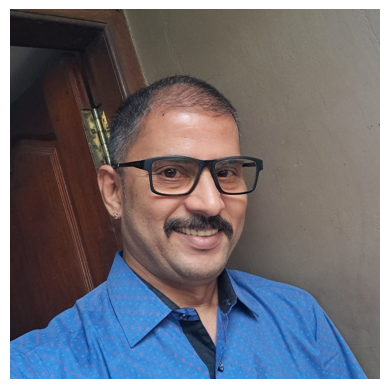

In [ ]:
result = predict_image(r"D:\OneDrive\Pictures\Saved Pictures\WhatsApp Image 2025-08-13 at 19.34.28_1f308333.jpg")